In [9]:
# Install dependencies
!pip install influxdb-client
!pip install pandas
!pip install matplotlib
!pip install openpyxl

In [10]:
# Imports
from influxdb_client import InfluxDBClient
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
from openpyxl import load_workbook
from openpyxl.styles import Font
from openpyxl.utils import get_column_letter

### Connect to InfluxDB

In [11]:
# Replace with your actual credentials
INFLUX_TOKEN    = "MBvDM01ijpsccsMMO0G_EG2ExJUq1sBZ4bLMAy1M8c5gDxJN8XAjp8ZzS49cLj6W8BTyTnm6GGYDEl7znTMHGg=="
INFLUX_HOST     = "https://us-east-1-1.aws.cloud2.influxdata.com"
INFLUX_BUCKET   = "Production"
INFLUX_ORG      = "c039d48f2e96a33a"

# Create the client
client = InfluxDBClient(url=INFLUX_HOST, token=INFLUX_TOKEN, org=INFLUX_ORG)

# Check if the connection is successful
try:
    client.ping()
    print("Connection to InfluxDB successful!")
except Exception as e:
    print(f"Failed to connect to InfluxDB: {e}")

Connection to InfluxDB successful!


### Create Speed query

In [12]:
query_api = client.query_api()

odo_query = f'''
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: 2025-04-30T08:00:00Z, stop: 2025-04-30T18:00:00Z)
  |> filter(fn: (r) => r._measurement == "Odometry")
  |> filter(fn: (r) => 
      r.asset_id == "cr8" or 
      r.asset_id == "cr9" or 
      r.asset_id == "cr10" or
      r.asset_id == "cr11" or
      r.asset_id == "cr12" or
      r.asset_id == "cr13" or
      r.asset_id == "cr14" or
      r.asset_id == "cr15")
  |> filter(fn: (r) => r._field == "odometer")
  |> keep(columns: ["asset_id", "_value", "_time"])
  |> rename(columns: {{_value: "odometer", _time: "time_stamp"}})
'''

# Run query
tables = query_api.query(odo_query)

### Create pandas table

In [13]:
records = []
for table in tables:
    for record in table.records:
        records.append({
            "asset_id": record["asset_id"],
            "odometer": record["odometer"],
            "time_stamp": record["time_stamp"]
        })

df = pd.DataFrame(records)

# Convert time column to datetime
df["time_stamp"] = pd.to_datetime(df["time_stamp"]).dt.tz_localize(None)
#df["time_stamp"] = pd.to_datetime(df["time_stamp"], utc=True)

df = df.sort_values("time_stamp")
print(df)

      asset_id    odometer                 time_stamp
25067      cr9  506.471344 2025-04-30 08:00:00.215402
7149      cr12  374.325255 2025-04-30 08:00:01.956441
3568      cr11  399.230815 2025-04-30 08:00:02.019388
10734     cr13  368.199428 2025-04-30 08:00:02.942402
0         cr10  359.886391 2025-04-30 08:00:05.741174
...        ...         ...                        ...
17904     cr14  414.911337 2025-04-30 17:59:55.051054
25066      cr8  521.329801 2025-04-30 17:59:57.129503
3567      cr10  360.971278 2025-04-30 17:59:57.841080
7148      cr11  399.944163 2025-04-30 17:59:58.855749
28651      cr9  507.897109 2025-04-30 17:59:59.014044

[28652 rows x 3 columns]


### Plot Chart

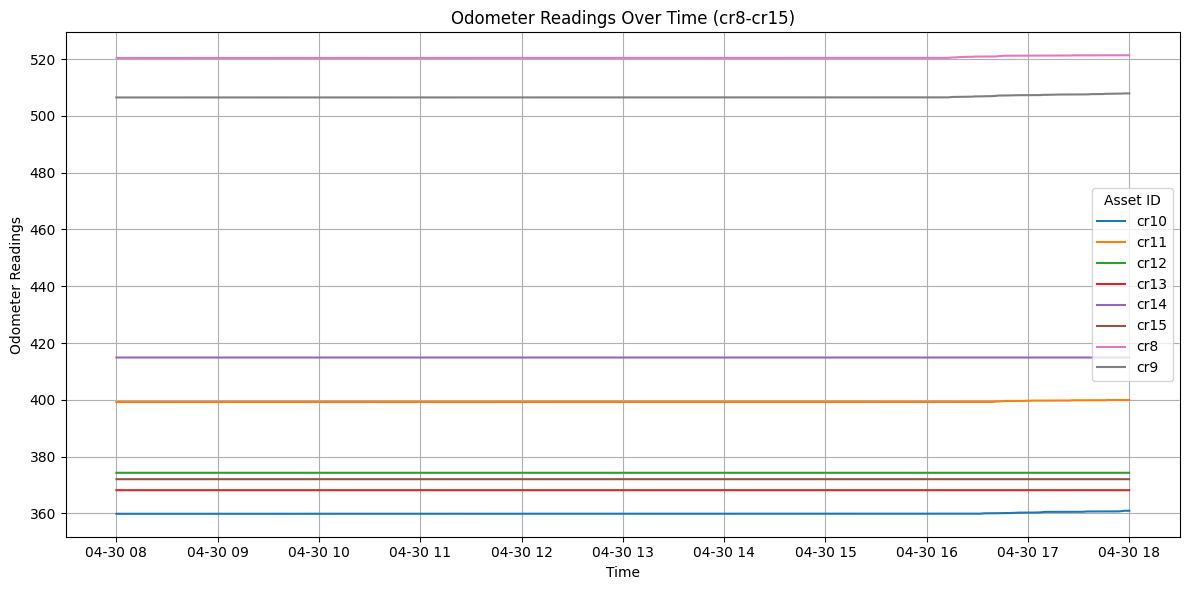

In [14]:
plt.figure(figsize=(12, 6))
for asset_id, group in df.groupby("asset_id"):
    plt.plot(group["time_stamp"], group["odometer"], label=asset_id)

plt.title("Odometer Readings Over Time (cr8-cr15)")
plt.xlabel("Time")
plt.ylabel("Odometer Readings")
plt.legend(title="Asset ID")
plt.grid(True)
plt.tight_layout()
plt.show()

### Excel Export

In [15]:
excel_filename = "/Users/mariorodriguez/Downloads/odometer_readings_by_asset.xlsx"

# Write each asset_id to its own sheet
with ExcelWriter(excel_filename, engine='openpyxl') as writer:
    for asset_id, group in df.groupby("asset_id"):
        group.to_excel(writer, sheet_name=asset_id, index=False)

workbook = load_workbook(excel_filename)
for sheet_name in workbook.sheetnames:
    ws = workbook[sheet_name]

    for cell in ws[1]:
        cell.font = Font(bold=True)

    for col in ws.columns:
        max_length = 0
        column_letter = get_column_letter(col[0].column)
        for cell in col:
            try:
                cell_len = len(str(cell.value))
                if cell_len > max_length:
                    max_length = cell_len
            except:
                pass
        ws.column_dimensions[column_letter].width = max_length + 2

    # Freeze header row
    ws.freeze_panes = "A2"

workbook.save(excel_filename)

print("Done exporting excel file!")

Done exporting excel file!


### CSV Export

In [16]:
csv_filename = "/Users/mariorodriguez/Downloads/odometer_readings_by_asset.csv"
df.to_csv(csv_filename, index=False)

print("Done exporting csv file!")

Done exporting csv file!
